In [2]:
from foodbornenyc.db_settings import twitter_config

consumer_key = twitter_config['consumer_key']
consumer_secret = twitter_config['consumer_secret']
access_token = twitter_config['access_token']
access_token_secret = twitter_config['access_token_secret']

In [97]:
from twython import TwythonStreamer
from shapely.geometry import Polygon # for comparing bounding boxes efficiently
from collections import deque
import json
import codecs

class FoodBorneStreamer(TwythonStreamer):
    """Custom streaming endpoint class. Defines how to handle incoming tweets"""
    def __init__(self, *args, **kwargs):
        TwythonStreamer.__init__(self, *args, **kwargs)
        self.counter = 0
        self.count_limit = 20
        self.error_counter = 0
        self.error_limit = 10
        self.follow = deque(maxlen=5000)
        self.tweets = []
        self.incidents = []
        self.output_tweets = 'stream_tweets1.json'
        self.output_incidents = 'stream_incidents1.json'
        
    def on_success(self, data):
        if 'text' not in data: return
        if self.in_incident(data): #takes care of adding status to incident if True
            print "Tweet involves tracked user %r:" % (data['user'])
            print self.counter, ":: ", data['text'].encode('utf-8')
            print
            self.tweets.append(data)
            self.counter +=1
        
        elif self.in_trackterms(data) and self.in_box(data):
            print "NEW INCIDENT"
            print self.counter,':: ',data['text'].encode('utf-8')
            #print data['user'].keys()
            print
            
            self.create_incident(data)
            self.update_follow_list()
            self.tweets.append(data)
            self.save_tweet(data)
            self.counter +=1
            
        if self.counter >= self.count_limit:
            self.counter = 0
            self.save_incidents()
            self.disconnect()
    
        if self.counter % 10 == 0:
            self.save_incidents()
    
    def on_error(self, status_code, data):
            print "Error status code: ", status_code
            self.error_counter += 1
            if self.error_counter >= self.error_limit:
                self.error_counter = 0
                self.save_incidents()
                self.disconnect()
                
    def run_dynamic_stream(self, filter_params):
        # initial dynamic params
        self.track = filter_params['track']
        self.location = filter_params['locations']
        
        self.statuses.set_dynamic_filter(track=','.join(self.track), 
                                         locations=','.join(self.location))
        self.statuses.dynamic_filter()
                
    def in_box(self, status):
        """recreate twitter filter to check if a tweet is in the bounding box
            1. See if coordinates in box
            2. check if place polygon intersects box
        """
        #try:
        if not self.location: 
            return True # no bounding box => anything is valid
        locationbox = [(float(self.location[0]), float(self.location[1])), (float(self.location[0]), float(self.location[3])),\
                        (float(self.location[2]), float(self.location[1])), (float(self.location[2]), float(self.location[3]))]
        if status['coordinates']:
            c = status['coordinates']
            if c['type'] == u'Point':
                coord = c['coordinates']
                if coord[0] <= self.location[0] and coord[0] >= self.location[2]\
                and coord[1] >= self.location[1] and coord[1] <= self.location[3]:
                    return True
                else:
                    return False
            elif c['type'] == u'Polygon':
                loc = Polygon([tuple(point) for point in c['coordinates']])
                box = Polygon(locationbox)
                if loc.intersects(box):
                    return True
                else:
                    return False
        elif status['place']:
            if status['place']['bounding_box']['type'] == u'Point':
                coord = status['place']['bounding_box']['coordinates']
                if coord[0] <= self.location[0] and coord[0] >= self.location[2]\
                and coord[1] >= self.location[1] and coord[1] <= self.location[3]:
                    return True
                else:
                    return False
            elif status['place']['bounding_box']['type'] == u'Polygon':
                loc = Polygon([tuple(point) for point in status['place']['bounding_box']['coordinates']][0])
                box = Polygon(locationbox)
                if loc.intersects(box):
                    return True
                else:
                    return False
        else:
            return False
        #except:
        #    print "ERROR IN_BOX"
        #    return False
        
    def in_trackterms(self, status):
        try:
            if not self.track: return True # no terms means all pass
            for term in self.track:
                if term in status['text']: return True
            return False
        except:
            return False
        
    def in_incident(self, status):
        if len(self.incidents) == 0: return False
        added = False
        for incident in self.incidents:
            added = incident.add_if_in_this_incident(status)
        return added    
    
    def update_follow_list(self):
        self.follow = deque([i.user['id'] for i in self.incidents if not i.is_over()], maxlen=5000)
        
    def create_incident(self, status):
        self.incidents.append(Incident(status))
        
    def save_tweet(self, status):
        with codecs.open(self.output_tweets, 'a', encoding='utf-8') as f:
            f.write(json.dumps(status)+'\n')
            
    def save_incidents(self):
        with codecs.open(self.output_incidents, 'w', encoding="utf-8") as f:
            for incident in self.incidents:
                f.write(json.dumps(incident.as_dict())+'\n')
                

In [16]:
stream = FoodBorneStreamer(consumer_key, consumer_secret, access_token, access_token_secret)

In [22]:
"""API LIMITS:
Follow: up to 5000 ids
Locations: up to 25 boxes
Terms: up to 400 terms"""
boundingbox = []#['-74.259090','40.491370','-73.700272','40.915256'] # SW -> NE
trackterms=['#foodpoisoning',
            '#stomachache',
            'food poison',
            'food poisoning',
            'stomach',
            'vomit',
            'vomited',
            'puke',
            'puked',
            'diarrhea',
            'the runs',
            'got sick',
            '#theruns',
            'cool'
            ]
follow = []
filterparams = {'locations':boundingbox, 'track':trackterms, 'follow':follow}

In [18]:
# old_follow = stream.follow
# old_tweets = stream.tweets
# print len(tweets)

In [19]:
stream = FoodBorneStreamer(consumer_key, consumer_secret, access_token, access_token_secret)


In [255]:
from twython import Twython
twitter = Twython(consumer_key, consumer_secret, access_token, access_token_secret)

In [257]:
tests = twitter.get_user_timeline(screen_name='tommyeffland')
for t in tests:
    print t['text']
    print t['geo'],', ', t['coordinates'],', ', t['place']
    print

Test 5
{u'type': u'Point', u'coordinates': [40.80960442, -73.96121137]} ,  {u'type': u'Point', u'coordinates': [-73.96121137, 40.80960442]} ,  {u'full_name': u'Manhattan, NY', u'url': u'https://api.twitter.com/1.1/geo/id/01a9a39529b27f36.json', u'country': u'United States', u'place_type': u'city', u'bounding_box': {u'type': u'Polygon', u'coordinates': [[[-74.026675, 40.683935], [-73.910408, 40.683935], [-73.910408, 40.877483], [-74.026675, 40.877483]]]}, u'contained_within': [], u'country_code': u'US', u'attributes': {}, u'id': u'01a9a39529b27f36', u'name': u'Manhattan'}

Test 4
None ,  None ,  {u'full_name': u'Joe', u'url': u'https://api.twitter.com/1.1/geo/id/07d9dd0921480000.json', u'country': u'United States', u'place_type': u'poi', u'bounding_box': {u'type': u'Polygon', u'coordinates': [[[-73.96180629730225, 40.809976486485596], [-73.96180629730225, 40.809976486485596], [-73.96180629730225, 40.809976486485596], [-73.96180629730225, 40.809976486485596]]]}, u'contained_within': [], 

In [23]:
#stream.statuses.set_dynamic_filter(locations=boundingbox)
#stream.statuses.dynamic_filter()
#stream.statuses.sample()
stream.run_dynamic_stream(filterparams)

1 ::  RT @jazyjaz1d: cool sind wir #1DAT

2 ::  This is an incredibly designed bathroom. The pixelated tile in the shower is unbelievably cool, albeit a bit ecce... https://t.co/2M5vTeTGpH

3 ::  happy birthday Hugo, hope ur day is as cool as you🤗😎 @HugoooAlves

4 ::  RT @digitaljournal: Check out this cool photo essay of avant-garde #fashion at the @Museumofvan https://t.co/XRIER4wZGi ^MC

5 ::  RT @MyBELLAWE: https://t.co/k8dDrATFeq 
#jewelry #design #fashion #luxury #style #unique #art #beautiful  #cool 
#trend #model… https://t.c…

6 ::  RT @5SECONDSOFSTEF: Michael is cool 

#MTVStars 5 Seconds Of Summer

7 ::  RT @iHarryNavy: @luke_brooks tweet #1DAT to show that you're cool and hot

8 ::  RT @ryanellisracing: @DaleJr cool to race with one of the guys I look up to most last weekend! #RookieStripe https://t.co/SGOr9oolkR

9 ::  @meagananders live-photos are so effing cool tho man. #cantwaittilluhavetheseprobstoo

10 ::  Omg me &amp; Irene just smoke sum good bud bud w/ ah couple co

KeyboardInterrupt: 

In [224]:
print stream.follow

deque([463860666, 299714481, 3299925044, 3254290707, 1838249203, 3037140440, 3296227784, 987994399, 1239611395, 4128622012], maxlen=5000)


### Testing out Incidents

In [29]:
import json
import codecs
from twython import Twython
twitter = Twython(consumer_key, consumer_secret, access_token, access_token_secret)

In [25]:
tweets = [ json.loads(l) for l in codecs.open('../stream_tweets1.json', 'r', encoding='utf8').readlines()]

In [26]:
print tweets[0]

{u'contributors': None, u'truncated': False, u'text': u'My stomach is killinggggg me', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 666750775096385536, u'favorite_count': 0, u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1447800747070', u'entities': {u'user_mentions': [], u'symbols': [], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': None, u'in_reply_to_user_id': None, u'retweet_count': 0, u'id_str': u'666750775096385536', u'favorited': False, u'user': {u'follow_request_sent': None, u'profile_use_background_image': True, u'id': 2343347891, u'verified': False, u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/664626134060040193/RXGusrwa_normal.jpg', u'profile_sidebar_fill_color': u'DDEEF6', u'is_translator': False, u'geo_enabled': True, u'profile_text_color': u'333333', u'followers_count': 846, u'protected': False, u'location'

In [32]:
replies = [tweet for tweet in tweets if tweet['in_reply_to_status_id']]
for r in replies:
    print r
    print
reply_ids = [str(r['in_reply_to_status_id']) for r in replies]

{u'contributors': None, u'truncated': False, u'text': u'@sofiyoe I had tears! And my stomach started hurting', u'is_quote_status': False, u'in_reply_to_status_id': 666809876501405696, u'id': 666811090748235776, u'favorite_count': 0, u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1447815127442', u'entities': {u'user_mentions': [{u'indices': [0, 8], u'screen_name': u'sofiyoe', u'id': 3669408315, u'name': u'.', u'id_str': u'3669408315'}], u'symbols': [], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': u'sofiyoe', u'in_reply_to_user_id': 3669408315, u'retweet_count': 0, u'id_str': u'666811090748235776', u'favorited': False, u'user': {u'follow_request_sent': None, u'profile_use_background_image': True, u'id': 575106641, u'verified': False, u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/666431333938233344/cH6BRhtc_normal.jpg', u'profile_sidebar_fill_

In [33]:
back1 = twitter.lookup_status(id=','.join(reply_ids))

In [37]:
for r in back1:
    print r
    print

{u'contributors': None, u'truncated': False, u'text': u'@King_Shit5 \U0001f602\U0001f602\U0001f602\U0001f602\U0001f602 man you was dying before', u'is_quote_status': False, u'in_reply_to_status_id': 666809506253418496, u'id': 666809876501405696, u'favorite_count': 1, u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', u'retweeted': False, u'coordinates': None, u'entities': {u'symbols': [], u'user_mentions': [{u'id': 575106641, u'indices': [0, 11], u'id_str': u'575106641', u'screen_name': u'King_Shit5', u'name': u'MEEK\u26a1\ufe0f'}], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': u'King_Shit5', u'id_str': u'666809876501405696', u'retweet_count': 0, u'in_reply_to_user_id': 575106641, u'favorited': False, u'user': {u'follow_request_sent': False, u'has_extended_profile': True, u'profile_use_background_image': True, u'default_profile_image': False, u'id': 3669408315, u'profile_background_image_url_https': u'https://pbs.twimg.com/pro

In [49]:
def backtrace_conversation(status):
    convo = deque()
    convo.append(status)
    reply_F = True
    while reply_F:
        in_reply_to = str(status['in_reply_to_status_id'])
        #print in_reply_to
        status = twitter.lookup_status(id=in_reply_to)[0]
        #print status
        convo.appendleft(status)
        if not status['in_reply_to_status_id']:
            reply_F = False
    return convo

In [50]:
convo = backtrace_conversation(replies[0])

666809876501405696
{u'contributors': None, u'truncated': False, u'text': u'@King_Shit5 \U0001f602\U0001f602\U0001f602\U0001f602\U0001f602 man you was dying before', u'is_quote_status': False, u'in_reply_to_status_id': 666809506253418496, u'id': 666809876501405696, u'favorite_count': 1, u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', u'retweeted': False, u'coordinates': None, u'entities': {u'symbols': [], u'user_mentions': [{u'id': 575106641, u'indices': [0, 11], u'id_str': u'575106641', u'screen_name': u'King_Shit5', u'name': u'MEEK\u26a1\ufe0f'}], u'hashtags': [], u'urls': []}, u'in_reply_to_screen_name': u'King_Shit5', u'id_str': u'666809876501405696', u'retweet_count': 0, u'in_reply_to_user_id': 575106641, u'favorited': False, u'user': {u'follow_request_sent': False, u'has_extended_profile': True, u'profile_use_background_image': True, u'default_profile_image': False, u'id': 3669408315, u'profile_background_image_url_https': u'https:

In [51]:
for t in convo:
    print t['text']
    print

butterscotch @King_Shit5

@sofiyoe lmfao omg stop 😂😂😂

@King_Shit5 lmaoo. 😂😂

@sofiyoe that's seriously the funniest thing ever I swear 😂

@King_Shit5 nobody will understand it on here tho😂

@sofiyoe 😂 so what, I understand and that shit has me in tears all over again 😂

@King_Shit5 😂😂😂😂😂 man you was dying before

@sofiyoe I had tears! And my stomach started hurting



In [114]:
from datetime import datetime, timedelta
def parse_twitter_timestamp(status):
    """ 
    Convert 'Wed Nov 18 15:40:46 +0000 2015' to datetime object
    Note: Python 2 can't handle the UTC offset '+0000', so slice around it
    """
    return datetime.strptime(status['created_at'][:-10] + status['created_at'][-4:], "%a %b %d %H:%M:%S %Y")

class Incident():
    """
    A data structure to keep track of local information about a pulled tweet.
    1. Keeps the the tweet filtered from the stream
    2. Gets this user's timeline going back up to 'timedelta' days
    3. Gets any conversation this tweet was involved in
    4. Tracks any future conversations this tweet is involved in
    """
    def __init__(self, status):
        self.start_date = parse_twitter_timestamp(status) # when the incident occured
        self.timedelta = timedelta(7) # in days, max number of days to keep from timeline
        self.conversations = [self._backtrace_conversation(status)] # all conversations involving this tweet
        self.user_timeline = self._get_user_timeline(status) # a deque of tweets by the user
        self.user = status['user']
        self.tweet0 = status['id']
        
    # public methods
    def is_over(self):
        if (self.start_date + self.timedelta) >= datetime.now():
            return True
        else:
            return False
    
    def add_if_in_this_incident(self, status):
        if self.is_over(): return False
        if status['user']['id'] == self.user['id']: # tweet involves this user
            # add to the timeline
            self.timeline.append(status)
            # add to any conversations if it was in one
            self._add_to_relevant_conversation(status)
            return True
        if status['in_reply_to_user_id'] == self.user['id']: # tweet was in reply to this user
            # add to any conversations if it was in one, else this reply isn't relevant
            added = self._add_to_relevant_conversation(status)
            return added
        return False
    
    def as_dict(self):
        return {
            'tweet0':self.tweet0,
            'start_date': datetime.strftime(self.start_date, "%a %b %d %H:%M:%S %Y"),
            'window': self.timedelta.days,
            'user': self.user,
            'timeline': list(self.user_timeline),
            'conversations':[ list(convo) for convo in self.conversations ]   
        }
    
    # private methods
    def _add_to_relevant_conversation(self, status):
        # note that each tweet can be in only one conversation thread, so always return on success
        reply_id = status['in_reply_to_user_id']
        if not reply_id: return False#no conversations if this wasn't a reply
        for convo in self.conversations:
            # if in reply to the end of a thread, just add it to that convo
            if reply_id == convo[-1]:
                convo.append(status)
                return True
            # now check if this response is to an earlier tweet in the convo, splitting into another convo
            for i, id in enumerate([status['id'] for status in reversed(convo)]): #traverse convo reverse chronologically
                # don't split conversations if they split before the tweet that caused the incident
                if id == self.tweet0:
                    if reply_id == id:
                        new_convo = deque(list(convo)[:len(convo)-i] + [status])
                        self.conversations.append(new_convo)
                        return True
                    else: break # got all the way back to tweet0 and reply wasn't involved, so stop analyzing this convo
                if reply_id == id:
                        new_convo = deque(list(convo)[:len(convo)-i] + [status])
                        self.conversations.append(new_convo)
                        return True
        return False
                    
    def _get_user_timeline(self, status):
        user_timeline = twitter.get_user_timeline(id=str(status['user']['id']))
        timeline = deque()
        backlimit = parse_twitter_timestamp(status) - self.timedelta
        for t in user_timeline:
            if parse_twitter_timestamp(t) >= backlimit:
                timeline.appendleft(t)
        return timeline 
        
    def _backtrace_conversation(self, status):
        convo = deque()
        convo.append(status)
        if not status['in_reply_to_status_id']: return convo # no replies to backtrace
        reply_F = True
        while reply_F:
            in_reply_to = str(status['in_reply_to_status_id'])
            status = twitter.lookup_status(id=in_reply_to)[0]
            convo.appendleft(status) # keep conversation in chronological order
            if not status['in_reply_to_status_id']:
                reply_F = False
        return convo
    
    

In [53]:
#twitter.get_user_timeline(id=str(status['user']['id']))
user_id = '41634520'
timeline = twitter.get_user_timeline(id=user_id)
print len(timeline)

20


In [80]:
for t in timeline:
    print t['text']
    print

Everything Wrong With America's Syrian Refugee Policy In One Graph https://t.co/naffs8oPPZ

Question of the Day: Should we let Syrian refugees into the United States? Weigh in using #Hannity

Next on #Hannity: @SarahPalinUSA weighs in on governors around the country taking a stand against Syrian refugees in their states.

.@RepMcCaul: “I think the president’s playing Russian roulette with the American people’s safety &amp; national security issues." #Hannity

.@RepMcCaul: “We cannot assure the American people that we can protect their safety bringing these refugees into the country.” #Hannity

Still to come: @RepMcCaul &amp; @RandPaul discuss their concerns about Syrian refugees in the U.S. #Hannity

.@MarkSteynOnline: Pres. Obama “stood there in front of the world… &amp; announced that he would be doing nothing.” #Hannity

Coming Up on #Hannity:  @MarkSteynOnline reacts to my interview with @realDonaldTrump &amp; Pres. Obama’s press conference yesterday.

.@realDonaldTrump: @HillaryCl

In [73]:
from datetime import datetime, timedelta

In [90]:
delta = timedelta(7)
print parse_twitter_timestamp(timeline[0]) - delta
print type(delta.days)
# for t in timeline:
#     print t['created_at']
#     print datetime.strptime(t['created_at'][:-10] + t['created_at'][-4:], "%a %b %d %H:%M:%S %Y")
#     print

2015-11-11 15:40:46
<type 'int'>


In [86]:
# reverse testing
convo = deque(range(10))
for i in reversed(convo):
    print i
print convo
convo.reverse()
print convo
print convo[-1]
convo.reverse()
print list(convo)[:len(convo)-3]

9
8
7
6
5
4
3
2
1
0
deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
deque([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
0
[0, 1, 2, 3, 4, 5, 6]


### Test the new streamer with incidents

In [115]:
"""API LIMITS:
Follow: up to 5000 ids
Locations: up to 25 boxes
Terms: up to 400 terms"""
boundingbox = []#['-74.259090','40.491370','-73.700272','40.915256'] # SW -> NE
trackterms=['#foodpoisoning',
            '#stomachache',
            'food poison',
            'food poisoning',
            'stomach',
            'vomit',
            'vomited',
            'puke',
            'puked',
            'diarrhea',
            'the runs',
            'got sick',
            '#theruns',
            'cool'
            ]
follow = []
filterparams = {'locations':boundingbox, 'track':trackterms, 'follow':follow}
stream = FoodBorneStreamer(consumer_key, consumer_secret, access_token, access_token_secret)

In [116]:
stream.run_dynamic_stream(filterparams)

NEW INCIDENT
0 ::  @froothoweIl @AmazingPhil its so cool, im so cool, coolşör clara

NEW INCIDENT
1 ::  Is Thermal Technology cool or not? https://t.co/c2EHan7Vs1

NEW INCIDENT
2 ::  RT @Louis_Tomlinson: Heard my mum is hanging out with some cool little people today ❤️ Olivia, Spencer &amp; Harvey X

NEW INCIDENT
3 ::  RT @NiallOfficial: #MadeInTheAM having a great time on this promo run. doing some really cool shows , havin a laugh..

NEW INCIDENT
4 ::  @DinaaELH @Cyrilhanouna cool

NEW INCIDENT
5 ::  Ma mère a oublié qu'il y a la réunion parents profs vendredi c'est plutôt cool ça

NEW INCIDENT
6 ::  @ad_schmidt wow that's cool

NEW INCIDENT
7 ::  RT @dog_rates: Those are sunglasses and a jean jacket. 11/10 dog cool af https://t.co/uHXrPkUEyl

NEW INCIDENT
8 ::  @marknorm I don't know, I think I'd be kind of cool to have famous AIDS.

NEW INCIDENT
9 ::  RT @GinaEPA: Happy #AmericaRecyclesDay! Learn some cool tips on recycling at https://t.co/Bg1IaHqO93, and pass them on. https://t.co

## How many incidents so far?

In [135]:
import json
incidents = []
with open('../stream_incidents2.json') as f:
    for l in f.readlines():
        incidents.append(json.loads(l))

In [127]:
print len(incidents)

400


In [124]:
i0 = dict(incidents[0])

In [130]:
print i0['start_date']

Fri Nov 20 16:26:28 2015


In [125]:
print len(i0['conversations'])

1


In [129]:
import datetime

In [136]:
dates = []
for i in incidents:
    i['start_date'] = datetime.datetime.strptime(i['start_date'], '%a %b %d %H:%M:%S %Y')
    dates.append(i['start_date'])

In [137]:
date_range = (min(dates), max(dates))

In [138]:
print date_range

(datetime.datetime(2015, 11, 20, 16, 26, 28), datetime.datetime(2015, 12, 3, 15, 57, 43))


In [139]:
# number of convos
convos = [ c for i in incidents for c in i['conversations'] ]

In [140]:
print len(convos)

400


In [142]:
avglen = sum([ len(c) for c in convos]) / float(len(convos))

(array([ 316.,    0.,   42.,    0.,    0.,   19.,    0.,    0.,    7.,
           0.,    0.,    6.,    0.,    3.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           1.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  1.  ,   1.36,   1.72,   2.08,   2.44,   2.8 ,   3.16,   3.52,
          3.88,   4.24,   4.6 ,   4.96,   5.32,   5.68,   6.04,   6.4 ,
          6.76,   7.12,   7.48,   7.84,   8.2 ,   8.56,   8.92,   

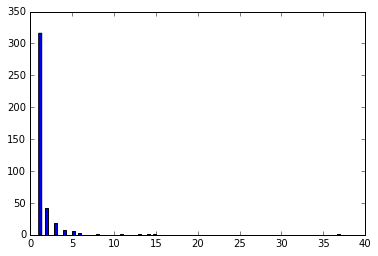

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([len(c) for c in convos], 100)

In [155]:
sconvos = sorted(zip([len(c) for c in convos], convos), key= lambda x:x[0], reverse=True)

In [159]:
for s, c in sconvos:
    if s > 1:
        for t in c:
            print t['text']
    print        

If I throw another ghetty I need five beer bong tables instead of three
@SamuraiWubz you let me know when you throw a ghetty
@CorrvptCriminal b2b 😏
@SamuraiWubz you tryna throw down a set?
@CorrvptCriminal of course I'm gonna throw down a set its my ghetty I didn't throw down at my last party
@SamuraiWubz count me in on a set.
@CorrvptCriminal @SamuraiWubz special guest luicsito
@luicsito @SamuraiWubz no moombahton at this party papo!
@CorrvptCriminal @SamuraiWubz stop being ignant
@luicsito @CorrvptCriminal don't bring my mom in this
@SamuraiWubz @CorrvptCriminal aight aight I'm special to your bitch *cough* *cough* Julian 😆😆😆😆😆😆😆😆😁😁
@luicsito @SamuraiWubz ummm ok
@CorrvptCriminal @SamuraiWubz and Julian your playing at moombah mansion so stfu with that shit that's a moombahton only party
@luicsito @SamuraiWubz lol are you dumb?  Does he run moombah mansion? ? NO
@CorrvptCriminal @SamuraiWubz that's not what I'm saying you dipshit
@luicsito @CorrvptCriminal @SamuraiWubz lol?
@ElDJDURO